# Artificial Neural Network for chest CT image distinction

### Training with cross validation of 10 folds


Model was trained to distinguish 3 classes: (A) CT of the chest, (B) CT of other parts of the body and (C) any images
- Convolutional Neural network
- Transferlearning: VGG16 from the kernel 56
- The training was carried out with kfold = 10
- Each fold a new VGG16 is inserted
- batch_size = 10
- image shape = 224, 224
- epoch = 10

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras import applications
from tensorflow.keras.models import Sequential 
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16
import tensorflow as tf
import pandas as pd
import numpy as np
import glob, os
from sklearn.model_selection import KFold
import datetime
import multiclass_metrics
import matplotlib.pyplot as plt
from IPython.display import Markdown

### Dataset description

In [2]:
split = pd.read_csv('split_train_val_test.csv',index_col = [0])
split.index = ['chest_tc','others_tc','no_tc']
split['Total'] = split.sum(axis=1)
split.loc['Total'] = split.sum()
split.loc['Total','Train %'] = int(round(split.loc['Total','Train']/split.loc['Total','Total']*100))
split.loc['Total','Validation %'] = int(round(split.loc['Total','Validation']/split.loc['Total','Total']*100))
split.loc['Total','Test %'] = int(round(split.loc['Total','Test']/split.loc['Total','Total']*100))
split

,Train,Train %,Validation,Validation %,Test,Test %,Total
chest_tc,82698,60,27566,20,27566,20,137930
others_tc,88587,60,29455,20,29456,20,147598
no_tc,70972,60,23657,20,23658,20,118387
Total,242257,60,80678,20,80680,20,403915


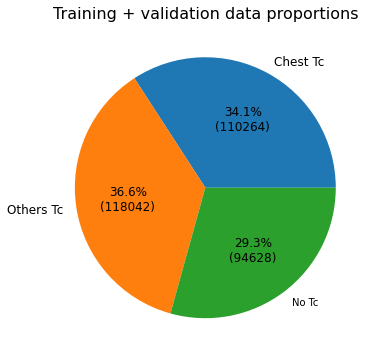

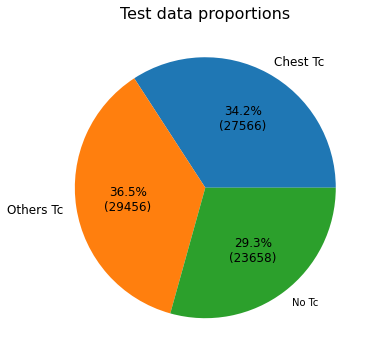

In [3]:
with tf.device('/gpu:2'): #gpu 0 estava ocupada
    ## Proporções dos dados de Treinamento

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))

    sum_chest_tc = split['Train']['chest_tc'] + split['Validation']['chest_tc']
    sum_others_tc = split['Train']['others_tc'] + split['Validation']['others_tc']
    sum_no_tc = split['Train']['no_tc'] + split['Validation']['no_tc']

    recipe = [str(sum_chest_tc), str(sum_others_tc), str(sum_no_tc)]
    data = [float(x.split()[0]) for x in recipe]

    def func(pct, allvals):
        absolute = int(pct/100.*np.sum(allvals))
        return "{:.1f}%\n({:d})".format(pct, absolute)

    wedges, texts, autotexts = ax.pie(data, labels=['Chest Tc','Others Tc','No Tc'], autopct=lambda pct: func(pct, data), textprops=dict(color="k"))
    texts[0].set_fontsize(12)
    texts[1].set_fontsize(12)

    plt.setp(autotexts, size=12)
    # plt.legend(labels=group_names,loc="best")
    ax.set_title("Training + validation data proportions", size=16)
    plt.show()

    ##Proporções dos dados de teste
    fig2, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))

    sum_chest_tc = split['Test']['chest_tc']
    sum_others_tc = split['Test']['others_tc'] 
    sum_no_tc = split['Test']['no_tc']

    recipe = [str(sum_chest_tc), str(sum_others_tc), str(sum_no_tc)]
    data = [float(x.split()[0]) for x in recipe]

    def func(pct, allvals):
        absolute = int(pct/100.*np.sum(allvals))
        return "{:.1f}%\n({:d})".format(pct, absolute)

    # return "{:.1f}%\n({:d})".format(pct, absolute)
    wedges, texts, autotexts = ax.pie(data, labels=['Chest Tc','Others Tc','No Tc'], autopct=lambda pct: func(pct, data), textprops=dict(color="k"))
    texts[0].set_fontsize(12)
    texts[1].set_fontsize(12)

    plt.setp(autotexts, size=12)
    # plt.legend(labels=group_names,loc="best")
    ax.set_title("Test data proportions", size=16)
    plt.show()

### Import VGG16 pre-trained model

In [4]:
img_width, img_height = 224, 244 
batch_size = 10

vgg16 = applications.VGG16(include_top=False, weights='imagenet',input_shape=(img_width, img_height, 3))
display(vgg16.summary())

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 244, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 244, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 244, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 122, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 122, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 122, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 61, 128)       0     

None

### Freezing layers of VGG16 before the kernel 56

In [5]:
with tf.device('/gpu:2'): #gpu 0 estava ocupada
        # Freeze n number of layers from the last
    for layer in vgg16.layers[:-12]: layer.trainable = False

    for layer in vgg16.layers: print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f773e6b8350> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f773f162950> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f773856b610> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f77384ebc10> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f77384da9d0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f7738542550> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f77384f39d0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f7738480290> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f7738484b90> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f773848bfd0> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f7738493e50> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f

### Dataframe for flow_from_directory

In [6]:
dataframe = pd.read_csv('dataframe.csv')
dataframe

,id,label
0,/scratch/v_project/diagnosticos/pre_processing...,chest_tc
1,/scratch/v_project/diagnosticos/pre_processing...,chest_tc
2,/scratch/v_project/diagnosticos/pre_processing...,chest_tc
3,/scratch/v_project/diagnosticos/pre_processing...,chest_tc
4,/scratch/v_project/diagnosticos/pre_processing...,chest_tc
...,...,...
403610,/scratch/v_project/diagnosticos/pre_processing...,no_tc
403611,/scratch/v_project/diagnosticos/pre_processing...,no_tc
403612,/scratch/v_project/diagnosticos/pre_processing...,no_tc
403613,/scratch/v_project/diagnosticos/pre_processing...,no_tc


### Training model with cross validaiton

In [ ]:
model_name = 'valid_CT_model'

# Setting kfolad
i = 1
kfolds = 10
df_metricas = pd.DataFrame()
kf = KFold(n_splits = kfolds, shuffle = True, random_state = None)
for train_index, test_index in kf.split(dataframe):
    trainData = dataframe.iloc[train_index]
    testData = dataframe.iloc[test_index]
    display(Markdown('### Starting Kfold %s\n'%str(i)))
    print('Train shape:',trainData.shape)
    print('Test shape:',testData.shape)
    epochs = 10 #tem que ser definido dentro do loop

    train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
    test_datagen = ImageDataGenerator(rescale=1. / 255) 

    train_generator=train_datagen.flow_from_dataframe(
    dataframe=trainData,
    directory="./train/",
    x_col="id",
    y_col="label",
    subset="training",
    batch_size=batch_size,
    shuffle=True,
    class_mode="categorical",
    target_size=(img_width, img_height))

    validation_generator=train_datagen.flow_from_dataframe(
        dataframe=trainData,
        directory="./train/",
        x_col="id",
        y_col="label",
        subset="validation",
        batch_size=batch_size,
        shuffle=True,
        class_mode="categorical",
        target_size=(img_width, img_height))

    test_generator=test_datagen.flow_from_dataframe(
        dataframe=testData,
        directory="./test/",
        x_col="id",
        y_col="label",
        batch_size=1,
        shuffle=False,
        class_mode="categorical",
        target_size=(img_width, img_height))

    num_classes = len(train_generator.class_indices) 
    print('Quantidade de classes:',num_classes)
    # get the class labels for the training data, in the original order 
    train_labels = train_generator.classes
    train_labels = to_categorical(train_labels, num_classes=num_classes)
    # get the class labels for the training data, in the original order 
    validation_labels = validation_generator.classes  
    # convert the training labels to categorical vectors 
    validation_labels = to_categorical(validation_labels, num_classes=num_classes)
    # get the class labels for the training data, in the original order 
    test_labels = test_generator.classes 
    # convert the training labels to categorical vectors 
    test_labels = to_categorical(test_labels, num_classes=num_classes)

    # insert VGG16 model
    vgg16 = applications.VGG16(include_top=False, weights='imagenet',input_shape=(img_width, img_height, 3))
    for layer in vgg16.layers[:-12]: layer.trainable = False

    #create the model
    model = Sequential()
    #Add the vgg convolutional base model
    model.add(vgg16)
    #ADd new layers
    model.add(Flatten()) 
    model.add(Dense(100, activation=tf.keras.layers.LeakyReLU(alpha=0.3))) 
    model.add(Dropout(0.5)) 
    model.add(Dense(50, activation=tf.keras.layers.LeakyReLU(alpha=0.3)))
    model.add(Dropout(0.3)) 
    model.add(Dense(num_classes, activation='softmax'))

    display(model.summary())

    # Backlog parameters
    log_path = os.path.join('./out/' + model_name + '_%s.log'%str(i))
    os.makedirs(log_path, exist_ok = True)
    csv_log = CSVLogger(os.path.join(log_path, model_name + '_kfold_%s.log'%str(i)))

    model_path = os.path.join('./out/H5',model_name)
    os.makedirs(model_path, exist_ok = True)
    filepath = (os.path.join(model_path, model_name + '_{epoch:02d}_AC{acc:.3f}_VAC{val_acc:.3f}_L{loss:.5f}_VL{val_loss:.5f}_kfold_%s.h5'%str(i)))

    callbacks_list = [ModelCheckpoint(filepath,
                                      monitor='val_acc',
                                      include_optimizer=False,
                                      save_best_only=True),
                      EarlyStopping(monitor='val_acc', patience=20, restore_best_weights=True), csv_log]

    model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=1e-4),metrics=['acc'])

    history = model.fit(train_generator,
                        epochs=epochs,
                        validation_data=validation_generator,
                        callbacks=callbacks_list,
                        verbose=1)

    # save model
    model.save(os.path.join(model_path,model_name + '_kfold_%s.h5'%str(i)))
    model.save_weights(os.path.join(model_path,model_name'_weights_kfold_%s.h5'%str(i)))
    start = datetime.datetime.now()

    (eval_loss, eval_accuracy) = model.evaluate( 
        validation_generator,use_multiprocessing=True)
    print('[INFO] accuracy: {:.2f}%'.format(eval_accuracy * 100)) 
    print('[INFO] Loss: {}'.format(eval_loss)) 
    end = datetime.datetime.now()
    elapsed = end-start
    print ('Time to evaluate: ', elapsed)

    # Graphing our training and validation
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))
    plt.figure(figsize=(15, 5))
    plt.plot(epochs, acc, 'r', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.ylabel('accuracy') 
    plt.xlabel('epoch')
    plt.legend()
    plt.ylim(0,1)
    plt.show()

    plt.figure(figsize=(15, 5)) 
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.ylabel('loss') 
    plt.xlabel('epoch')
    plt.legend()
    plt.ylim(0,1)
    plt.show()

    start = datetime.datetime.now()
    preds = np.round(model.predict(test_generator),0)
    print('rounded test labels',preds)
    end = datetime.datetime.now()
    elapsed= end-start
    print ('Time to predict: ', elapsed)

    save_path = './out/metrics' + model_name + '/kfold_%s'%str(i)

    classes = ['Chest Tc','Others Tc','No Tc']
    metricas = multiclass_metrics.get_metrics(test_labels, preds, class_names=classes,save_path=save_path)
    df_metricas = pd.concat([df_metricas,metricas])
    df_metricas.to_csv(os.path.join(save_path,'df_metricas_all_folds'),index=False)
    display(metricas)

    multiclass_metrics.plot_graphics(test_labels,preds, class_names=classes,save_path=save_path)
    i += 1

display(Markdown('All folds computed - kfold = %s'%str(kfolds)))
display(df_metricas)
display(Markdown('Metrics averages computed with kfold = %s'%str(kfolds)))
display(df_metricas.mean())
display(Markdown('Standard deviation of metrics computed with kfold = %s'%str(kfolds)))
display(df_metricas.std())


In [ ]:
loss_mean = list()
vloss_mean = list()
loss_std = list()
vloss_std = list()
for i in range(1,kfolds + 1):
    treinamentoLOG = pd.read_csv('./out/' + model_name + '_%s.log'%str(i))
    loss_mean.append(treinamentoLOG['loss'].mean())
    vloss_mean.append(treinamentoLOG['loss'].std())
    loss_std.append(treinamentoLOG['val_loss'].mean())
    vloss_std.append(treinamentoLOG['val_loss'].mean())
loss_df = pd.DataFrame(columns=['loss mean','val loss mean','loss std','val loss std'])    
loss_df['loss mean'] = loss_mean
loss_df['val loss mean'] = vloss_mean  
loss_df['loss std'] = loss_std
loss_df['val loss std'] = vloss_std
loss_df.loc[len(loss_df)] = loss_df.mean()
loss_df = loss_df.rename(index={len(loss_df)-1:'Total'})
display(Markdown('### Loss Analyzed'))
display(loss_df)